#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt


In [2]:
# Note: For code documentation, most functions and classes have accompanying docstrings that you can access via the help() function in IPython, e.g.: help(SliceDataset)
# help(fastmri.data.mri_data.SliceDataset)


The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI'
dicom_path = os.path.join(download_path,'fastMRI_brain_DICOM')
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')

In [3]:
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name),'r')

In [5]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0004274357358916608, 'norm': 0.09131797120370877, 'patient_id': 'dcfc3e70496246a709dab23831262b60589f4383d6e05bf5559731ea8d80bb1f'}


Read important information about the imaging sequence that was used

In [6]:
import xmltodict

header = xmltodict.parse(hf['ismrmrd_header'][()])
reconSpace = header['ismrmrdHeader']['encoding']['reconSpace']   # ['matrixSize', 'fieldOfView_mm']
measurementInformation = header['ismrmrdHeader']['measurementInformation']   # ['measurementID', 'patientPosition', 'protocolName', 'frameOfReferenceUID']
acquisitionSystemInformation = header['ismrmrdHeader']['acquisitionSystemInformation']   # ['systemVendor', 'systemModel', 'systemFieldStrength_T', 'relativeReceiverNoiseBandwidth' 'receiverChannels', 'coilLabel', 'institutionName']
H1resonanceFrequency_Hz = header['ismrmrdHeader']['experimentalConditions']['H1resonanceFrequency_Hz']
sequenceParameters = header['ismrmrdHeader']['sequenceParameters']   # ['TR', 'TE', 'TI', 'flipAngle_deg', 'sequence_type', 'echo_spacing']

pixelSizeX = float(reconSpace['fieldOfView_mm']['x'])/float(reconSpace['matrixSize']['x'])
pixelSizeY = float(reconSpace['fieldOfView_mm']['y'])/float(reconSpace['matrixSize']['y'])

print(reconSpace)
print(measurementInformation)
print(acquisitionSystemInformation)
print(H1resonanceFrequency_Hz)
print(sequenceParameters)
print(pixelSizeX)
print(pixelSizeY)


OrderedDict([('matrixSize', OrderedDict([('x', '320'), ('y', '320'), ('z', '1')])), ('fieldOfView_mm', OrderedDict([('x', '220'), ('y', '220'), ('z', '5')]))])
OrderedDict([('measurementID', '45219_136713935_136713944_1189'), ('patientPosition', 'HFS'), ('protocolName', 'AX FLAIR_FBB'), ('frameOfReferenceUID', '1.3.12.2.1107.5.2.19.45219.1.20190613092200672.0.0.0')])
OrderedDict([('systemVendor', 'SIEMENS'), ('systemModel', 'Skyra'), ('systemFieldStrength_T', '2.8936'), ('relativeReceiverNoiseBandwidth', '0.793'), ('receiverChannels', '20'), ('coilLabel', [OrderedDict([('coilNumber', '18'), ('coilName', 'HeadNeck_20:1:N12')]), OrderedDict([('coilNumber', '17'), ('coilName', 'HeadNeck_20:1:N11')]), OrderedDict([('coilNumber', '50'), ('coilName', 'HeadNeck_20:1:H14')]), OrderedDict([('coilNumber', '49'), ('coilName', 'HeadNeck_20:1:H13')]), OrderedDict([('coilNumber', '34'), ('coilName', 'HeadNeck_20:1:H23')]), OrderedDict([('coilNumber', '33'), ('coilName', 'HeadNeck_20:1:H24')]), Order

Explore generalized properties of the data using all training files

In [7]:
from pathlib import Path

# Cluster the training data based on number of coils used
#clustered_data = {}
#files = Path(train_path).glob('**/*')
#for file in files:
#   hf_loop = h5py.File(file)
#   shape = hf_loop['kspace'][()].shape
#   num_coils = shape[1]
#   if num_coils not in clustered_data:
#      clustered_data[num_coils] = [file]
#   else:
#      clustered_data[num_coils].append(file)

In [8]:
# Save dictionary to .npy file
#np.save("/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Preprocessing/exploration/coil_clustered_fastmri_data.npy", clustered_data)

# To load:
clustered_data = np.load("/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Preprocessing/exploration/coil_clustered_fastmri_data.npy", allow_pickle=True)
clustered_data = clustered_data.item()

In [9]:
for key, list in dict(clustered_data).items():
    print('Number of coils:'+str(key))
    print('Number of scans:'+str(len(list)))

# We can see that the most common number of coils are (in descending order) 16, 4 and 20

Number of coils:12
Number of scans:245
Number of coils:20
Number of scans:1173
Number of coils:4
Number of scans:1214
Number of coils:16
Number of scans:1434
Number of coils:14
Number of scans:264
Number of coils:5
Number of scans:22
Number of coils:6
Number of scans:61
Number of coils:24
Number of scans:7
Number of coils:18
Number of scans:26
Number of coils:2
Number of scans:7
Number of coils:8
Number of scans:10
Number of coils:10
Number of scans:3
Number of coils:28
Number of scans:2
Number of coils:22
Number of scans:1


In [10]:
# Cluster the 16-coil training data based on slice dimensions, as the 16-coil data corresponds to the most scans
#clustered_data_2 = {}
#for file in clustered_data[16]:
#    hf_loop = h5py.File(file)
#    shape = hf_loop['kspace'][()].shape
#    slice_height = shape[2]
#    slice_width = shape[3]
#    key = (slice_height,slice_width)
#    if key not in clustered_data_2:
#        clustered_data_2[key] = [file]
#    else:
#        clustered_data_2[key].append(file)


In [2]:
# To load:
clustered_data_2 = np.load("/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Preprocessing/exploration/16coil_slice_size_clustered_fastmri_data.npy", allow_pickle=True)
clustered_data_2 = clustered_data_2.item()

In [12]:
for key, list in clustered_data_2.items():
    print('Slice dimensions:'+str(key))
    print('Number of scans:'+str(len(list)))


Slice dimensions:(640, 320)
Number of scans:726
Slice dimensions:(768, 396)
Number of scans:630
Slice dimensions:(640, 272)
Number of scans:25
Slice dimensions:(768, 324)
Number of scans:4
Slice dimensions:(640, 274)
Number of scans:1
Slice dimensions:(640, 264)
Number of scans:27
Slice dimensions:(640, 280)
Number of scans:1
Slice dimensions:(512, 320)
Number of scans:1
Slice dimensions:(640, 332)
Number of scans:1
Slice dimensions:(512, 234)
Number of scans:4
Slice dimensions:(640, 260)
Number of scans:5
Slice dimensions:(640, 262)
Number of scans:2
Slice dimensions:(512, 256)
Number of scans:1
Slice dimensions:(512, 214)
Number of scans:3
Slice dimensions:(768, 342)
Number of scans:2
Slice dimensions:(640, 312)
Number of scans:1


In [13]:
# Save dictionary to .npy file
#np.save("/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Preprocessing/exploration/16coil_slice_size_clustered_fastmri_data.npy", clustered_data_2)

In [13]:
count_AXFLAIR = 0
count_AXT1 = 0
count_AXT2 = 0
count_others = 0

for filename in clustered_data_2[(640,320)]:
    filename = str(filename)
    if 'AXFLAIR' in filename:
        count_AXFLAIR += 1
    elif 'AXT1' in filename:
        count_AXT1 += 1
    elif 'AXT2' in filename:
        count_AXT2 += 1
    else:
        count_others += 1


In [8]:
print(f"AXFLAIR: {count_AXFLAIR}")
print(f"AXT1: {count_AXT1}")
print(f"AXT2: {count_AXT2}")
print(f"Others: {count_others}")


AXFLAIR: 95
AXT1: 407
AXT2: 224
Others: 0


In [9]:
count_AXFLAIR = 0
count_AXT1 = 0
count_AXT2 = 0
count_others = 0

for filename in clustered_data_2[(640,320)][:70]:
    filename = str(filename)
    if 'AXFLAIR' in filename:
        count_AXFLAIR += 1
    elif 'AXT1' in filename:
        count_AXT1 += 1
    elif 'AXT2' in filename:
        count_AXT2 += 1
    else:
        count_others += 1

In [10]:
print(f"AXFLAIR: {count_AXFLAIR}")
print(f"AXT1: {count_AXT1}")
print(f"AXT2: {count_AXT2}")
print(f"Others: {count_others}")


AXFLAIR: 7
AXT1: 37
AXT2: 26
Others: 0


In [12]:
for filename in clustered_data_2[(640,320)][:70]:
    print(str(filename))


/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_train/file_brain_AXT1_202_6000340.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_train/file_brain_AXFLAIR_200_6002493.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_train/file_brain_AXT2_202_2020075.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_train/file_brain_AXT2_202_2020327.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_train/file_brain_AXT2_206_2060005.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_train/file_brain_AXT1POST_210_6001724.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_train/file_brain_AXT1POST_210_6001704.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_train/file_brain_AXT1POST_202_6000351.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_train/file_brain_AXT2_202_2020583.h5
/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_train/file_brain_AXT1PRE_200_6002041.h5
/u

In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [4]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)


complex64
(16, 20, 640, 320)


In [5]:
slice_kspace = volume_kspace[10,:,:,:] # Choosing the 10-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [6]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)


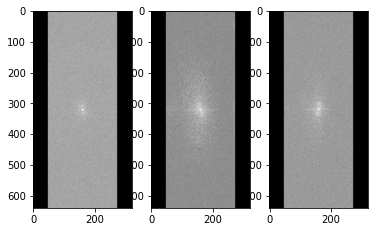

In [17]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10], cmap='gray')  # This shows coils 0, 5 and 10
# Note: np.abs() on complex data is the same as calculating the magnitude. 1e-9 is added to avoid log(0).


The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [8]:
import fastmri
from fastmri.data import transforms as T


In [9]:
slice_kspace_T = T.to_tensor(slice_kspace)               # Convert from numpy array to pytorch tensor
slice_image_T = fastmri.ifft2c(slice_kspace_T)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image_T)     # Compute absolute value to get a real image


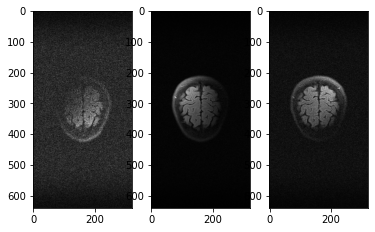

In [20]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [8]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
help(fastmri.rss)


Help on function rss in module fastmri.coil_combine:

rss(data:torch.Tensor, dim:int=0) -> torch.Tensor
    Compute the Root Sum of Squares (RSS).
    
    RSS is computed assuming that dim is the coil dimension.
    
    Args:
        data: The input tensor
        dim: The dimensions along which to apply the RSS transform
    
    Returns:
        The RSS value.



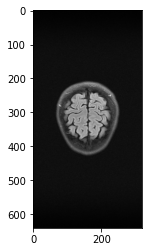

In [22]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')


In [9]:
slice_image_rss.max()


tensor(0.0003)

In [10]:
slice_image_rss.min()


tensor(3.8496e-06)

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [10]:
from fastmri.data.subsample import RandomMaskFunc

##############################################################################################################################
## IMPORTANT: HERE, WE USE RANDOM PE SAMPLING, NOT EQUIDISTANT SAMPLING, SIMILAR TO CS MASKS -> CREATES DIFFERENT ARTIFACTS ##
##############################################################################################################################
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])  # Create the mask function object
help(RandomMaskFunc)

Help on class RandomMaskFunc in module fastmri.data.subsample:

class RandomMaskFunc(MaskFunc)
 |  RandomMaskFunc creates a sub-sampling mask of a given shape.
 |  
 |  The mask selects a subset of columns from the input k-space data. If the
 |  k-space data has N columns, the mask picks out:
 |      1. N_low_freqs = (N * center_fraction) columns in the center
 |         corresponding to low-frequencies.
 |      2. The other columns are selected uniformly at random with a
 |      probability equal to: prob = (N / acceleration - N_low_freqs) /
 |      (N - N_low_freqs). This ensures that the expected number of columns
 |      selected is equal to (N / acceleration).
 |  
 |  It is possible to use multiple center_fractions and accelerations, in which
 |  case one possible (center_fraction, acceleration) is chosen uniformly at
 |  random each time the RandomMaskFunc object is called.
 |  
 |  For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04],
 |  then there is a 5

In [11]:
masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)   # Apply the mask to k-space

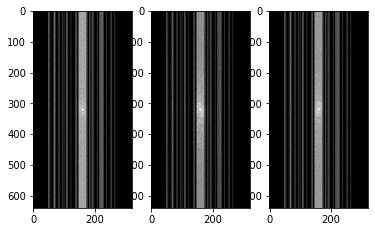

In [12]:
show_coils(np.log(np.abs(fastmri.complex_abs(masked_kspace_T).numpy()) + 1e-9), [0, 5, 10], cmap='gray')


Let's see what the subsampled image looks like:

In [13]:
sampled_image_T = fastmri.ifft2c(masked_kspace_T)                # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image_T)         # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)


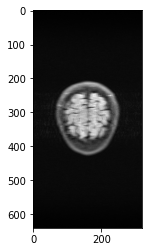

In [14]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

Let's see for R = 8

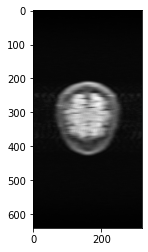

In [20]:
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])
masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
sampled_image_T = fastmri.ifft2c(masked_kspace_T)                # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image_T)         # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')


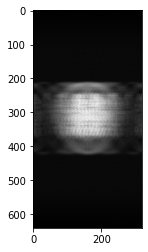

In [22]:
mask_func = RandomMaskFunc(center_fractions=[0.01], accelerations=[8])
masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
sampled_image_T = fastmri.ifft2c(masked_kspace_T)                # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image_T)         # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')


Test functions from the GrappaNet notebook

In [28]:
# Compare mask functions

def calculate_mask(nFE,nPE,center_fraction,acc):
    '''
    nFE: number of frequency encoding lines
    nPE: number of phase encoding lines
    center_fraction: fraction of central lines of full sampling
    acc: acceleration factor
    '''
    num_low_freqs = int(round(nPE * center_fraction))
    num_high_freqs = np.ceil(nPE/acc) - num_low_freqs 
    num_outer_lines = nPE - num_low_freqs
    line0 = np.repeat([True],num_high_freqs)
    line0 = np.append(line0,np.repeat([False],num_outer_lines-num_high_freqs))
    np.random.shuffle(line0)
    num_left = num_outer_lines//2
    line = np.append(line0[0:num_left],np.repeat([True],num_low_freqs))
    line = np.append(line,line0[num_left:num_outer_lines])

    mask = np.repeat(line[np.newaxis, ...], nFE, axis=0)
    
    return mask


In [ ]:
nSL, nCh, nFE, nPE = volume_kspace.shape
mask_2 = calculate_mask(nFE,nPE,0.08,4)
subsampled_k = volume_kspace*mask_2
show_coils(np.log(np.abs(subsampled_k[10,:,:,:]) + 1e-9), [0, 5, 10], cmap='gray')


Compare custom numpy rss calculation to fastmri rss

In [12]:
from numpy import fft 

nCh, nFE, nPE = slice_kspace.shape
ref_img = np.zeros((nCh,nFE,nPE),dtype=np.float32)

for channel in range(nCh):
    ref_img[channel,:,:] = abs(fft.fftshift(fft.ifft2(slice_kspace[channel,:,:])))


In [15]:
Y_rss = np.sqrt(np.sum(np.square(ref_img),axis=0))


In [16]:
Y_rss.max()


5.594781e-07

In [17]:
Y_rss.min()


8.50657e-09

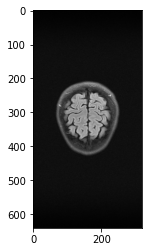

In [18]:
plt.imshow(np.abs(Y_rss), cmap='gray')


In [19]:
nCh, nFE, nPE = slice_kspace.shape
ref_img = np.zeros((nCh,nFE,nPE),dtype=np.float32)

for channel in range(nCh):
    ref_img[channel,:,:] = abs(fft.fftshift(fft.ifft2(slice_kspace[channel,:,:], norm='ortho')))


In [20]:
Y_rss = np.sqrt(np.sum(np.square(ref_img),axis=0))


In [21]:
Y_rss.max()


0.0002531909

In [22]:
Y_rss.min()


3.8496337e-06

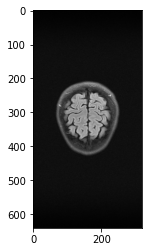

In [23]:
plt.imshow(np.abs(Y_rss), cmap='gray')
